<a href="https://colab.research.google.com/github/Damanpreet/Neural-Style-Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Neural Style Transfer ###

Neural Style Transfer is a technique that allows us to take two images - content and style image, and blend them together. We adopt the content of one image and style of the other image to form a new art. 
In other words, this renders the image in such a way that the new image adopts the style from the style image while retaining the content from the content image.

This was first introduced by Gatys et. al in 2015 ([A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)). Since then a lot of work has been done in this field to improve the results.

Checkout this link to find the information about the work done on this topic: https://paperswithcode.com/task/style-transfer

This script contains implementation of the paper - A Neural Algorithm of Artistic Style in Pytorch. I am using VGG19 Network to obtain the features of my content and style image as used in the original paper.  

In [0]:
# Import all the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import urllib.request
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [0]:
# device
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

#### Load the Images and preprocess them ####
Preprocessing images include -
1. Resizing the images
2. Converting image to Pytorch tensor
3. Normalize the image (subtract the mean)
4. Changing the image pixel values to the range 0-255

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp '/content/gdrive/My Drive/image3.jpg' '/content/image2.jpg'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# load the images and convert them into pytorch tensors
image_paths = ['https://i2.wp.com/catchupdates.com/wp-content/uploads/2014/06/infosys_mysore.jpg?fit=700%2C377&ssl=1&resize=1280%2C720', 'https://www.thegreatcoursesdaily.com/wp-content/uploads/2017/01/The-Acropolis-featured-image.jpg']
style_paths = ['https://static.boredpanda.com/blog/wp-content/uploads/2015/03/blind-painter-john-bramblitt-fb-1.jpg', 'https://i.pinimg.com/564x/d9/99/25/d99925f51e4fa4c16b899095832fd859.jpg', 'https://i.pinimg.com/originals/e3/b5/3f/e3b53f4328e3d9928ecb8d5bc38dfadd.jpg','https://www.vangoghgallery.com/catalog/image/0612/Starry-Night.jpg']

#'https://cdn1.vectorstock.com/i/1000x1000/01/30/paintings-with-marbling-marble-texture-paint-vector-22860130.jpg',

for i in range(len(image_paths)):
  urllib.request.urlretrieve(image_paths[i], 'image'+str(i)+'.jpg')
image_paths += ['']

for i in range(len(style_paths)):
  urllib.request.urlretrieve(style_paths[i], 'style'+str(i)+'.jpg')

# define the transform
img_size = 1024
transform = transforms.Compose([
  transforms.Resize((img_size, img_size)),
  transforms.ToTensor(),
  # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  transforms.Normalize([0.485, 0.456, 0.406], [1, 1, 1]),
  transforms.Lambda(lambda x: x.mul_(255.)),
])

image_contents, contents = [], []
for i in range(len(image_paths)):
  image_content = Image.open("image"+str(i)+".jpg")
  image_contents.append(image_content)
  content = transform(image_content)
  content = torch.unsqueeze(content, 0).to(device)        # add an arbitrary dimension for batch size, and assign the tensor to the device
  contents.append(content)

image_style, styles = [], []
for i in range(len(style_paths)):
  style_path = "style"+str(i)+".jpg"
  im_style = Image.open(style_path)
  image_style.append(im_style)
  im_style = transform(im_style)
  styles.append(torch.unsqueeze(im_style, 0).to(device))    # add an arbitrary dimension for batch size, and assign the tensor to the device

#### Helper Functions ####
1. Compute the gram matrix
2. Compute the gram loss
3. Compute the regularization loss

In [0]:
class Gram(nn.Module):
  def forward(self, image):
    '''
      Find the gram matrix of the image.

      Output:
      Returns the gram matrix.
    '''
    gram_mat = torch.mm(image, image.t())
    gram_mat.div_(image.shape[1])
    return gram_mat

class GramLoss(nn.Module):
  def forward(self, out_img, style_gram):
    '''
      Calculate the gram loss.
      
      Inputs:
      out_img - Noisy image features
      style_img - Gram matrix of Style image features
      
      Output:
      Value of the gram loss. Compute the mean square error between the output image and style image.
    '''
    return nn.MSELoss()(Gram()(out_img), style_gram)

def regularization_loss(image_gram):
  '''
    Returns the total variation loss/Regularization loss.
  '''
  return torch.sum(torch.abs(image_gram[:,:,:-1,:] - image_gram[:,:,1:,:])) + torch.sum(torch.abs(image_gram[:,:,:,:-1] - image_gram[:,:,:,1:]))

#### VGG19 Network ####

VGG19 was a breakthrough in the world of convolutional neural networks. VGG19 is a network which consists of 19 layers - 16 Convolution layers and 3 fully-connected layers. More details on VGG19 can be found [here](https://iq.opengenus.org/vgg19-architecture/).


Authors replaced all the max pooling operations with average pooling as it was found to give better results. 

We do not need the final three fully-connected layers, and just need to extract features of the image using the convolution layers. 

So we extract features from a higher layer in the VGG Network and use these as a high level content. The actual pixel values of the image is lost. 

####Extract content image features:####
In the original work, authors extract image features from the layer - Block 4, Conv 1.

####Extract style image features:####
For style image features, they extract features from the layers - Block 1, Conv 1; Block 2, Conv 1; Block 3, Conv 1; Block 4, Conv 1; Block 5, Conv 1.


In [0]:
class Net(nn.Module):
  def __init__(self, ch_config):
    super(Net, self).__init__()
    
    layers = []
    in_channels = 3
    kernel = 3

    # define the network layers
    for ch in ch_config:
      if ch == 'A':
        layers.append(nn.AvgPool2d(kernel_size=2, stride=2)) 
      else:
        layers.append(nn.Conv2d(in_channels, ch, kernel_size=kernel, padding=1))
        layers.append(nn.ReLU(inplace=True))
        in_channels = ch

    self.features = nn.Sequential(*layers)

  def forward(self, x):
    '''
      Forward pass
    '''
    x = self.features(x)
    return x
  
  def get_content_features(self, image):
    '''
      Retrieve the features of the content image from a higher layer.
      block4 conv2
    '''
    features = self.features[:23](image)
    return features

  def get_style_features(self, image):
    '''
      Retrieve the style features of the image from a higher layer.
      blocks - block1 conv1, block2 conv1, block3 conv1, block4 conv1, block5 conv1
    '''
    features = [self.features[:2](image), self.features[:7](image), self.features[:12](image), self.features[:21](image), self.features[:30](image)]
    return features

#### Initialize weights using a pretrained model ####
We do not need to train the VGG network, instead we use the pretrained weights provided by pytorch to initialize our model and extract image features.

In [0]:
def initialize_pretrained(pretrained, vgg19):
  model_state = vgg19.state_dict()
  urllib.request.urlretrieve(pretrained, 'vgg19.pth')
  pretrained_weights = torch.load('vgg19.pth')
  pretrained_weights = {k:v for k, v in pretrained_weights.items() if k in model_state}
  vgg19.load_state_dict(pretrained_weights)
  print("Weights loaded successfully!")

#### Create the model ####

In [0]:
config = [64, 64, 'A', 128, 128, 'A', 256, 256, 256, 256, 'A', 512, 512, 512, 512, 'A', 512, 512, 512, 512, 'A']
vgg19 = Net(config).to(device)

In [10]:
vgg19

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

#### Load the model weights and lock the gradients ####

We lock the gradients as we do not want these weights to be changed while training our model. 

In [11]:
# initialize pretrained weights
checkpoint_path = 'http://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
initialize_pretrained(checkpoint_path, vgg19)

# lock the gradients
for param in vgg19.parameters():
  param.require_grads = False

Weights loaded successfully!


#### Extract the content and style image features ####

In [0]:
# extract the style features 
style_grams = []
for style in styles:
  style_features = vgg19.get_style_features(style)
  style_gram = [Gram()(v.view(v.shape[1], -1)).detach() for v in style_features]
  style_grams.append(style_gram)

# extract the content features 
content_features = []
for content in contents:
  content_feature = vgg19.get_content_features(content).detach()
  content_features.append(content_feature.view(content_feature.shape[1], -1))

#### Hyperparameters ####

Define the hyperparameters for training

In [13]:
# number of epochs
n_epochs = 500

# params for adam
lr = 0.5e1
beta1 = 0.9
beta2 = 0.999

# content and style weight
content_wt = 10e0        #10e-4                                             
# style_wt = [2e6/(n**2) for n in [64, 128, 256, 512, 512]] 
style_wt = [1e2*n/32 for n in [64, 128, 256, 512, 512]]           
print(style_wt)

# regularization parameter for smoothness 
reg_param = 1e-5                                     

[200.0, 400.0, 800.0, 1600.0, 1600.0]


In [0]:
torch.backends.cudnn.benchmark = True

# Content loss
loss_content = nn.MSELoss()                                  

#### Training ####

Run the network for defined number of iterations to obtain the results.

The loss function that we optimize while training contains three terms.
1. For the content image
2. For the style image
3. Regularization term

Adjust the tradeoff between the content and style image to create visually appearing images.
            

In [15]:
outputs = []

# apply all styles to all the content images 
for c in range(len(contents)):
  for style_gram in style_grams:

    # output_image
    out_img = Variable(contents[c].data.clone(), requires_grad=True).to(device)

    # Adam optimizer
    optimizer = torch.optim.Adam([out_img], lr=lr, betas=(beta1, beta2))

    # training loop
    for ep in range(n_epochs):
      # style_loss.zero_()
      optimizer.zero_grad()                                                           # zero grad the gradients

      # loss on style image
      noise_style = vgg19.get_style_features(out_img)
      noise_style = [v.view(v.shape[1], -1) for v in noise_style]

      n = len(noise_style)
      style_loss_local = [style_wt[i] * GramLoss()(noise_style[i], style_gram[i]).cuda() for i in range(n)]
      style_loss = sum(style_loss_local)

      # loss on content image
      noise_content = vgg19.get_content_features(out_img)
      noise_content = noise_content.view(noise_content.shape[1], -1)
      content_loss = loss_content(noise_content, content_features[c]).to(device)
      
      reg_loss = regularization_loss(out_img)

      # define the total loss
      loss = content_loss*content_wt + style_loss + reg_loss*reg_param
      if torch.isnan(loss):
        break

      loss.backward()
      optimizer.step()

      if ep % 50 == 0:
        print("Epoch: {}, Loss: {:.2f}".format(ep, loss.item()))
      
      if torch.isnan(loss):
        break
      
    print("Final loss: {:.2f}".format(loss.item()))
    outputs.append(out_img.detach().to('cpu').squeeze())

Epoch: 0, Loss: 40992526336.00
Epoch: 50, Loss: 728532608.00
Epoch: 100, Loss: 224398160.00
Epoch: 150, Loss: 118829176.00
Epoch: 200, Loss: 77293152.00
Epoch: 250, Loss: 55636052.00
Epoch: 300, Loss: 42411648.00
Epoch: 350, Loss: 33566852.00
Epoch: 400, Loss: 27285138.00
Epoch: 450, Loss: 22646818.00
Final loss: 19177938.00
Epoch: 0, Loss: 36912021504.00
Epoch: 50, Loss: 417206656.00
Epoch: 100, Loss: 126967616.00
Epoch: 150, Loss: 68345536.00
Epoch: 200, Loss: 42809388.00
Epoch: 250, Loss: 28970926.00
Epoch: 300, Loss: 20698456.00
Epoch: 350, Loss: 15431852.00
Epoch: 400, Loss: 11916180.00
Epoch: 450, Loss: 9472659.00
Final loss: 7741783.00
Epoch: 0, Loss: 38876622848.00
Epoch: 50, Loss: 1960622976.00
Epoch: 100, Loss: 765618048.00
Epoch: 150, Loss: 251454432.00
Epoch: 200, Loss: 128020192.00
Epoch: 250, Loss: 81982184.00
Epoch: 300, Loss: 59315584.00
Epoch: 350, Loss: 46299028.00
Epoch: 400, Loss: 35373712.00
Epoch: 450, Loss: 25996472.00
Final loss: 35907544.00
Epoch: 0, Loss: 5591

#### Plot the results ####

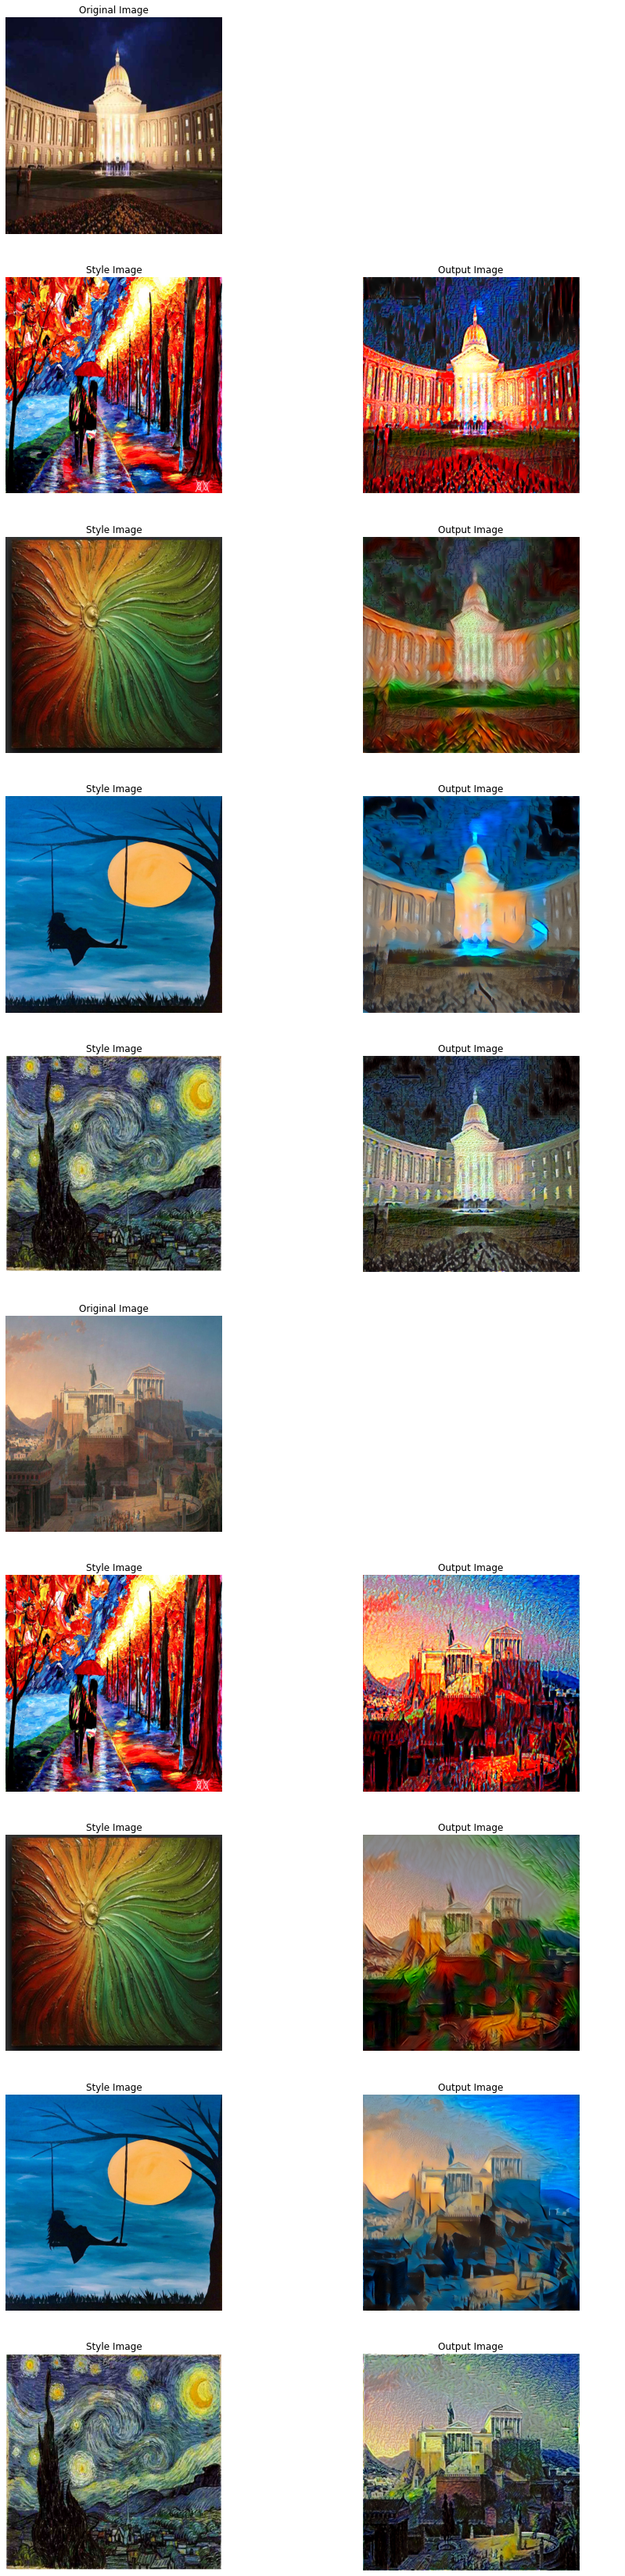

In [30]:
# Post processing the results
invtransform = transforms.Compose([
  transforms.Lambda(lambda x: x.mul_(1/255.)),
  transforms.Normalize([-0.485, -0.456, -0.406], [1, 1, 1]),
])

# Plot the results
fig, ax = plt.subplots(len(outputs)+len(image_contents)-len(image_style)-1, 2, figsize=(15, 60))

i, s = 0, 0
for image_content in image_contents[:-1]:
  ax[i, 0].imshow(image_content.resize((img_size, img_size)))
  ax[i, 0].axis('off')
  ax[i, 0].set_title("Original Image")
  ax[i, 1].axis('off')
  i+=1

  for im_style in image_style:
    out_image = outputs[s].clone()
    out_image = invtransform(out_image)
    torch.clamp(out_image, 0, 1, out=out_image)             # clip the image pixel values
    out_im = transforms.ToPILImage()(out_image)

    ax[i, 0].imshow(im_style.resize((img_size, img_size)))
    ax[i, 0].axis('off')
    ax[i, 0].set_title("Style Image")

    ax[i, 1].imshow(out_im)
    ax[i, 1].axis('off')
    ax[i, 1].set_title("Output Image")

    i+=1; s+=1